(quickstart)=
# Quickstart

Welcome to the Quickstart guide! This section will guide you through setting up BayesBay, defining a simple model, and running your first MCMC inversion. Before starting, ensure that BayesBay is installed (see our [Installation Guide](../installation)). The imports needed for this tutorial are below.

In [4]:
import bayesbay as bb

import matplotlib.pyplot as plt
import numpy as np

## Problem Definition

In this example, we will use BayesBay to infer the posterior distribution $p(m \mid d) \propto p(m) p(d \mid m)$, where both the model parameter $m$ and the observed data $d$ are real numbers. Specifically, we consider the case where $m = 10$ and $d \sim \mathcal{N}(m, \sigma^2)$, where $\sigma = 0.5$ denotes the data noise standard deviation. We will use a uniform prior $p(m) = \frac{1}{b - a} = 0.1$, defined over the interval $a = 5$ to $b = 15$.



## True Model and Observed Data

In [3]:
m_true = 10
sigma_true = 0.5
d = np.random.normal(m_true, sigma_true)

## Setting up the Bayesian sampling

To solve the inverse problem inherent to inferring $m$ from the observations, we need to define:

* A [Parameterization](../api/generated/bayesbay.parameterization.Parameterization), encapsulating the prior probability.
* A *forward function*, returning data predictions $d_{\text{pred}}$ at each Markov chain iteration. Through this function, the user is allowed access to the proposed model parameters through what we call a [State](../api/api_standard_states) (more about this later).
* What we refer to as a [Target](bayesbay.likelihood.Target), that is, a Python object designed to store all information about the observed data.

### Parameterization

First, let's define the uniform probability distribution mentioned earlier. This is readily done through the class [UniformPrior](../api/generated/bayesbay.prior.UniformPrior). (For different probability distributions, see the module [bayesbay.prior](../api/api_standard_prior).)

In [5]:
m_prior = bb.prior.UniformPrior(name="m", vmin=5, vmax=15, perturb_std=0.5)

## Forward operator and noisy observations

In the following code block we define the forward operator &mdash; which will be used later in the tutorial to generate data predictions based on the considered model coefficients &mdash; and the observed data.

In [3]:
fwd_operator = np.vander(DATA_X, N_DIMS, True)
y = fwd_operator @ [M0, M1, M2, M3]
y_noisy = y + np.random.normal(0, DATA_NOISE_STD, y.shape)

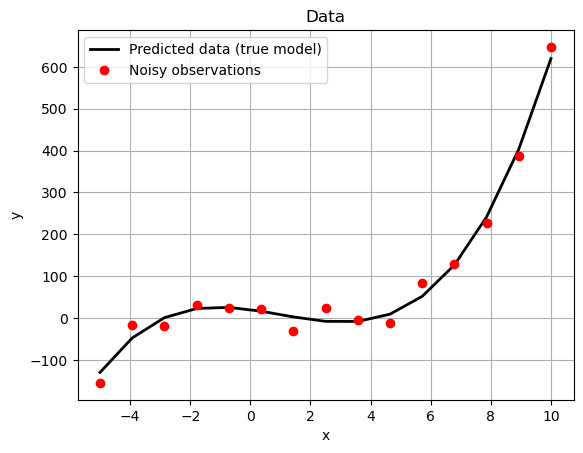

In [4]:
fig, ax = plt.subplots()
ax.set_title('Data')
ax.plot(DATA_X, y, 'k', lw=2, label='Predicted data (true model)')
ax.plot(DATA_X, y_noisy, 'ro', label='Noisy observations')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

To solve the inverse problem inherent in inferring the coefficients $\mathbf{m}$ from the observations, we need to define:

* A [Parameterization](../api/generated/bayesbay.parameterization.Parameterization), encapsulating the unknowns parameters and their prior probability
* A *forward function*, enabling the prediction of data points $\mathbf{d}_{pred}$ from the model $\mathbf{m}$
* What we refer to as a [Target](../api/generated/bayesbay.Target), that is, a Python object designed to store all information about a given data set

### **1. Prior probability**

Here, we assume that prior information on the sought parameters is available. For instance, while we may not know the true values of $m_1$ and $m_2$, we understand that these values are bounded within specific ranges, namely $-13\leq m_1 \leq7$ and $-10\leq m_2 \leq4$. As demonstrated in the following block, this prior information can be implemented through [UniformPrior](../api/generated/bayesbay.prior.UniformPrior), that is, a free parameter characterized by a uniform prior probability.

Conversely, we might know that $m_0$ and $m_3$ are likely associated with specific values, without, however, being able to provide hard bounds for such values. It is then natural to define the prior probabilities of these parameters using a Gaussian distribution. This is achieved in BayesBay through [GaussianPrior](../api/generated/bayesbay.prior.GaussianPrior). (Different options for the prior of a free parameter can be implemented via [CustomPrior](../api/generated/bayesbay.prior.CustomPrior).)

Finally, note the argument ``perturb_std`` in the below block, taken by both `UniformPrior` and `GaussianPrior`. The numerical value assigned to this argument represents the standard deviation of the Gaussian distribution used to propose a new model by perturbing the considered parameter at a given Markov-chain iteration.

In [5]:
m0 = bb.prior.GaussianPrior(name="m0", mean=20, std=1, perturb_std=0.5)
m1 = bb.prior.UniformPrior(name="m1", vmin=-13, vmax=-7, perturb_std=0.4)
m2 = bb.prior.UniformPrior(name="m2", vmin=-10, vmax=4, perturb_std=0.5)
m3 = bb.prior.GaussianPrior(name="m3", mean=1, std=0.1, perturb_std=0.1)

### **2. Parameter space and parameterization**

The free parameters we have defined, regardless of their prior probability, should be used in BayesBay to create what we call a [ParameterSpace](../api/generated/bayesbay.parameterization.ParameterSpace). Mathematically, `ParameterSpace` can be thought of as a $n$-dimensional vector space. Each point (vector) within this space corresponds to a free parameter in the inference problem, and the position of each point defines the model parameters $\mathbf{m}_i \in \mathbb{R}^n$, with $\mathbf{m}_i \subseteq \mathbf{m}$. Importantly, in our implementation $n$ can be treated as a variable to enable trans-dimensional Bayesian sampling.

From a computer programming perspective, `ParameterSpace` could be seen as a specialized container that not only groups a number of free parameters but also determines their dimensionality. For instance, in this tutorial's case, `ParameterSpace` will contain four distinct free parameters (namely, the unknown coefficients $m_0$, $m_1$, $m_2$, and $m_3$), and since these are scalars, its dimensionality will remain fixed and equal to one throughout the inversion. Finally, under the hood `ParameterSpace` also defines the perturbation functions used to propose new model parameters from the given ones (for more information, see the module [bayesbridge.perturbations](../api/api_standard_perturbations)).

Having defined one or more instances of `ParameterSpace`, these should be used to define a [Parameterization](../api/generated/bayesbay.parameterization.Parameterization). `Parameterization` is a relatively simple object compared to `ParameterSpace`, and its main purpose is to aggregate all model parameters (from all specified instances of `ParameterSpace`) to define $\mathbf{m} = \lbrace \mathbf{m}_1, \mathbf{m}_2, \mathbf{m}_3, \dots \rbrace$.

In [6]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=1, 
    parameters=[m0, m1, m2, m3], 
)
parameterization = bb.parameterization.Parameterization(param_space)

### **3. Forward problem**

Another fundamental ingredient in BayesBay is the definition of the forward function. This function is required to return the predicted data in the form of a numpy array, which is then used to calculate the likelihood $p({\bf d}_{obs} \mid {\bf m})$. As illustrated in the code block below, the forward function should be programmed to take in a [bayesbay.State](../api/generated/bayesbay.State), from which all model parameters can be accessed.

In [7]:
def fwd_function(state: bb.State) -> np.ndarray:
    m = [state["my_param_space"][f"m{i}"] for i in range(N_DIMS)]
    return np.squeeze(fwd_operator @ m) # dpred = G m

### **4. Observed data: the Target**

In BayesBay, the observed data, $\mathbf{d}_{obs}$ should be used to define what we call a data [Target](../api/api_standard_target), which, as demonstrated in [Part II: Hierarchical Sampling](hierarchical_linregr), allows for treating the data noise as an unknown. Here, we assume the data noise is known and use the true noise standard deviation to define the inverse of the data covariance matrix.

In [8]:
target = bb.Target(
    name="my_data", 
    dobs=y_noisy, 
    covariance_mat_inv=1/DATA_NOISE_STD**2)

### **5. Log Likelihood**

Having defined the forward function and the target, these can be used to initialize an instance of the [LogLikelihood](../api/generated/bayesbay.LogLikelihood) class. (Alternatively, such an instance can be initialized through a function that either calculates $\log(p({\bf d}_{obs} \mid {\bf m}))$ or $\log \left( \frac{p(\mathbf{d}_{obs} \mid \mathbf{m}')}{p(\mathbf{d}_{obs} \mid \mathbf{m})}\right)$, where $\mathbf{m}'$ denotes the proposed model.) The `LogLikelihood` instance represents the last ingredient needed to run the Bayesian sampling.

In [9]:
log_likelihood = bb.LogLikelihood(targets=target, fwd_functions=fwd_function)

## Run the Bayesian sampling

We can now use all the defined variables to solve the inference problem. The code provided below is self-explanatory. We sample the posterior using ten Markov chains, each run on a separate CPU for 50,000 iterations. (To modify the number of CPUs employed in the sampling, see the argument ``parallel_config`` in [bayesbay.BayesianInversion.run()](../api/generated/bayesbay.BayesianInversion).) The first 20,000 iterations are discarded as the burn-in phase. After the burn-in, we save one model every 100 iterations.


Notice the arguments ``targets`` and ``fwd_functions`` of [bayesbay.BayesianInversion](../api/generated/bayesbay.BayesianInversion): rather than accepting only one data target and forward function, as defined earlier, these can accept a list of targets and a list of functions. This flexibility makes it straightforward to carry out joint inversions of multiple datasets, each potentially associated with different forward functions.

In [10]:
inversion = bb.BayesianInversion(
    log_likelihood=log_likelihood, 
    parameterization=parameterization, 
    n_chains=10
)
inversion.run(
    n_iterations=50_000, 
    burnin_iterations=20_000, 
    save_every=100, 
    verbose=False, 
)

In [14]:
for chain in inversion.chains:
    chain.print_statistics()

Chain ID: 0
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 5655/50000 (11.31 %)
PARTIAL ACCEPTANCE RATES:
	ParamPerturbation(['my_param_space.m0', 'my_param_space.m1', 'my_param_space.m2', 'my_param_space.m3']): 5655/50000 (11.31%)
Chain ID: 1
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 5393/50000 (10.79 %)
PARTIAL ACCEPTANCE RATES:
	ParamPerturbation(['my_param_space.m0', 'my_param_space.m1', 'my_param_space.m2', 'my_param_space.m3']): 5393/50000 (10.79%)
Chain ID: 2
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 5542/50000 (11.08 %)
PARTIAL ACCEPTANCE RATES:
	ParamPerturbation(['my_param_space.m0', 'my_param_space.m1', 'my_param_space.m2', 'my_param_space.m3']): 5542/50000 (11.08%)
Chain ID: 3
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 5662/50000 (11.32 %)
PARTIAL ACCEPTANCE RATES:
	ParamPerturbation(['my_param_space.m0', 'my_param_space.m1', 'my_param_space.m2', 'my_param_space.m3']): 5662/50000 (11.32%)
Chain ID: 4
TEMPERATURE: 1
EXPLORED MODE

## Retrieve the results and plot

In the following block, we first retrieve the samples collected during the inference by calling ``inversion.get_results()``. We then plot all the saved predicted data along with their median.

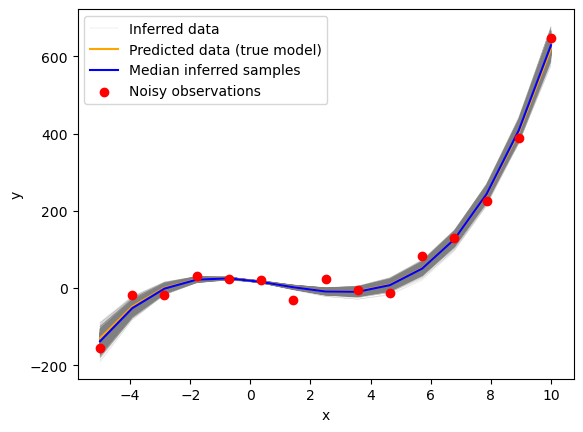

In [12]:
results = inversion.get_results()

fig, ax = plt.subplots()
y_pred = np.array(results["my_data.dpred"])
ax.plot(DATA_X, y_pred[0], c='gray', lw=0.3, alpha=0.3, label="Inferred data")
ax.plot(DATA_X, y_pred[1:].T, c='gray', lw=0.3, alpha=0.3)
ax.plot(DATA_X, y, c='orange', label='Predicted data (true model)')
ax.plot(DATA_X, np.median(y_pred, axis=0), c="blue", label='Median inferred samples')
ax.scatter(DATA_X, y_noisy, c='r', label='Noisy observations', zorder=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

Finally, we create a figure that displays the inferred polynomial coefficients, with yellow dots indicating the true values. This is achieved using the [ArviZ](https://python.arviz.org/en/latest/index.html) library, which provides useful functionalities for plotting inference results.

/home/fabrizio/mambaforge/envs/seislib/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (3000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/fabrizio/mambaforge/envs/seislib/lib/python3.9/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


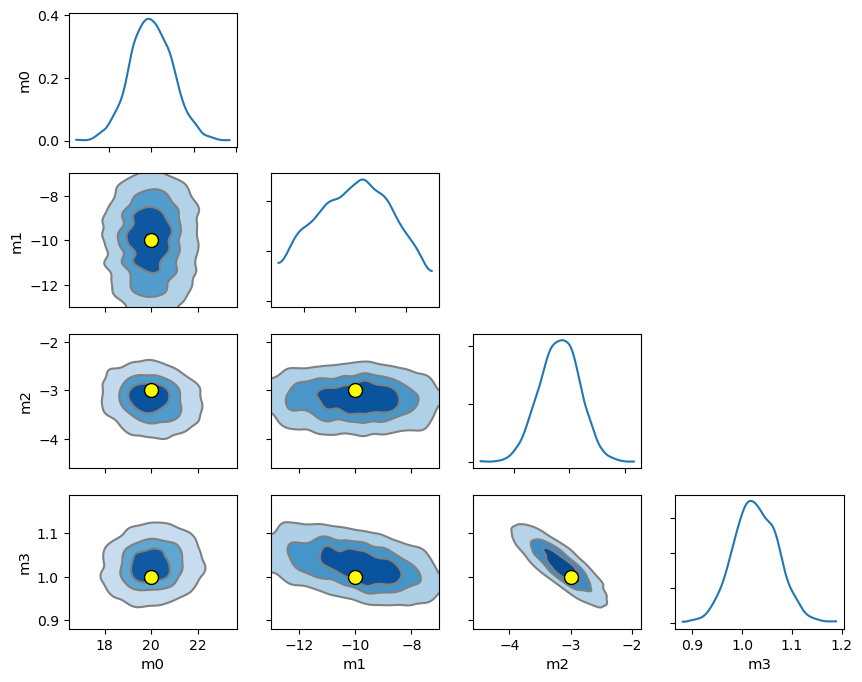

In [13]:
import arviz as az

fig, axes = plt.subplots(4, 4, figsize=(10, 8))

samples = {f'm{i}': results[f'my_param_space.m{i}'] for i in range(4)}
_ = az.plot_pair(
    samples,
    marginals=True,
    reference_values={'m0': M0, 'm1': M1, 'm2': M2, 'm3': M3},
    reference_values_kwargs={'color': 'yellow',
                             'ms': 10},
    kind='kde',
    kde_kwargs={
        'hdi_probs': [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        'contourf_kwargs': {'cmap': 'Blues'},
        },
    ax=axes,
    textsize=10
    )